In [1]:
import numpy as np
from random import random, uniform
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
from calc import distance, intersection, parallel, angle, orthogonal
from draw import draw
from line import Line
from plane import Plane
from point import Point
from solver import solve
from vector import Vector

__all__ = (
    "Line",
    "Plane",
    "Point",
    "Vector",
    "angle",
    "distance",
    "draw",
    "intersection",
    "orthogonal",
    "parallel",
    "solve",
)

In [3]:
def get_angles(points):
    # вычисление угла
    cnt = points
    num_points = len(cnt)
    angles = []
    for i, point in enumerate(cnt):
        point1 = cnt[i - 1]
        point2 = cnt[i]
        point3 = cnt[(i + 1) % num_points]
        angles.append(int(Vector(point2, point1).angle(Vector(point2, point3))* 180 / np.pi))

    return np.array(angles)

In [4]:
class Cube():
    #куб с вершиной А в нуле координат и заданной длиной ребра, находится в первой полуплоскости для каждй пары осей
    def __init__(self, side=1, center=Point(0.5, 0.5, 0.5)):
        
        
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(a, a, 0) + vec
        self.D = Point(0, a, 0) + vec
        self.E = Point(0, 0, a) + vec
        self.F = Point(a, 0, a) + vec
        self.G = Point(a, a, a) + vec
        self.H = Point(0, a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F, self.G, self.H]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AD = Line(self.A, self.D)
        self.DC = Line(self.D, self.C)
        
        self.AE = Line(self.A, self.E)
        self.BF = Line(self.B, self.F)
        self.CG = Line(self.C, self.G)
        self.DH = Line(self.D, self.H)
        
        self.EF = Line(self.E, self.F)
        self.EH = Line(self.E, self.H)
        self.FG = Line(self.F, self.G)
        self.HG = Line(self.H, self.G)
        
        self.iterable_edges = [self.AB, self.BC, self.AD, self.DC, self.AE, self.BF,
                               self.CG, self.DH, self.EF, self.EH, self.FG, self.HG]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            # intersect is actually (num, point)
            return (
                # <3 Python's comparison operator
                self.A.x <= point.x <= self.G.x and
                self.A.y <= point.y <= self.G.y and
                self.A.z <= point.z <= self.G.z
            )
        intersections = list(filter(in_bounds, intersections))
        
        
        if intersections:
            polygon = [intersections.pop()]
            while intersections:
                last = polygon[-1]
                distances = [distance(last, x) for x in intersections]
                # We're only interested in the index of the next point,
                # this min function returns the minimum (index, distance)
                # tuple...
                successor = min(enumerate(distances), key=lambda x: x[1])
                # ...but we only need the index :)
                successor = successor[0]
                polygon.append(intersections.pop(successor))

            return polygon
        else:
            return []

In [5]:
def make_random_plane(n=10):
    #в кубе с левой нижней вершиной 0,0,0 а правой верхней n,n,n
    center = Point(n/2, n/2, n/2)
    cube = Cube(side=n, center=center)
    #генерируем два угла k1 и k2
    k1, k2 = np.tan(uniform(0, np.pi)), np.tan(uniform(0, np.pi))
    #рассматриваем случаи
    if k1 >= 0:
        xm = 0
        ym = 0
    else:
        xm = n
        ym = n
        k1 = -k1
    m1 = n/2-2**(0.5)/2*n*k1
    v1 = Vector(center, Point(xm, ym, m1))
    
    if k2 >= 0:
        xn = 0
        yn = n
    else:
        xn = n
        yn = 0
        k2 = -k2
    m2 = n/2-2**(0.5)/2*n*k2
    v2 = Vector(center, Point(xn, yn, m2))
    
    #m1 и m2 - потенциальные минимумы
    
    if m1 <= m2:
        x = xm
        y = ym
        m = m1
    else:
        x = xn
        y = yn
        m = m2
    
    #генерируем "сдвиг"
    z = uniform(2*m - n, n)
    #возвращаем плоскость по точке и двум векторам
    return Plane(Point(x, y, z), v1, v2)

In [6]:
# generate random plane
def generate_random_plane_angles(cube=Cube()):
    
    plane = make_random_plane(n=1)
    points_intersection = cube.intersection_with_plane(plane)
    if len(points_intersection) != 0:
        return get_angles(points_intersection)
    else:
        return []

In [7]:
def generates_n_plates(n=1000, side=1, center=(0.5, 0.5, 0.5)):
    
    cube = Cube(side=side, center=Point(center))
    angles = [0]*181
    
    for i in range(n):
        angs = generate_random_plane_angles(cube=cube)
        if len(angs) != 0:
            for ang in angs:
                angles[ang] += 1
    
    return list(np.array(angles)/np.sum(angles))

In [8]:
def generate_vertex_distribution(n=1000, side=1, center=(0.5, 0.5, 0.5)):
    cube = Cube(side=side, center=Point(center))
    
    vertex = [0]*7
    for i in range(n):
        angs = generate_random_plane_angles(cube)
        vertex[len(angs)] += 1
    
    return vertex

In [9]:
def make_table_vertex_distribution(n=1000, n_try=10):
    vertex_distrs = []
    for i in range(n_try):
        vertex_distrs.append(generate_vertex_distribution(n=n))

    vertex_distrs = np.array(vertex_distrs)/n*100
    mean = np.mean(vertex_distrs, axis=0)
    std = np.std(vertex_distrs, axis=0)
    var = np.var(vertex_distrs, axis=0)
    
    indexes = list(range(1, n_try+1)) + ['mean', 'std', 'dispersion']
    return pd.DataFrame(np.vstack((vertex_distrs, mean, std, var)), index=indexes)

i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(-0.4845730900724105, 0.0, 0.3444800391196656) Vector(-0.4845730900724105, 0.0, 0.3444800391196656)
i got a problem with arccos Vector(0.4845730900724105, 0.0, -0.3444800391196656) Vector(0.4845730900724105, 0.0, -0.3444800391196656)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(0.4836671811583314, 0.0, -0.7847151641330855) Vector(0.4836671811583314, 0.0, -0.7847151641330855)
i got a problem with arccos Vector(-0.4836671811583314, 0.0, 0.7847151641330855) Vector(-0.4836671811583314, 0.0, 0.7847151641330855)
i got a problem with arccos Vector(0.0, -1.1288255605590436e-05, 8.323943088583974e-06) Vector(0.0, -1.1288255605590436e-05, 8.323943088583974e-06)
i got a problem with arccos Vector(0.0, 1.1288255605590436e-05, -8.323943088583974e-06) Vector(0.0, 1.1288255605590436e-05, -8.323943088583974e-06)
i got a problem with arc

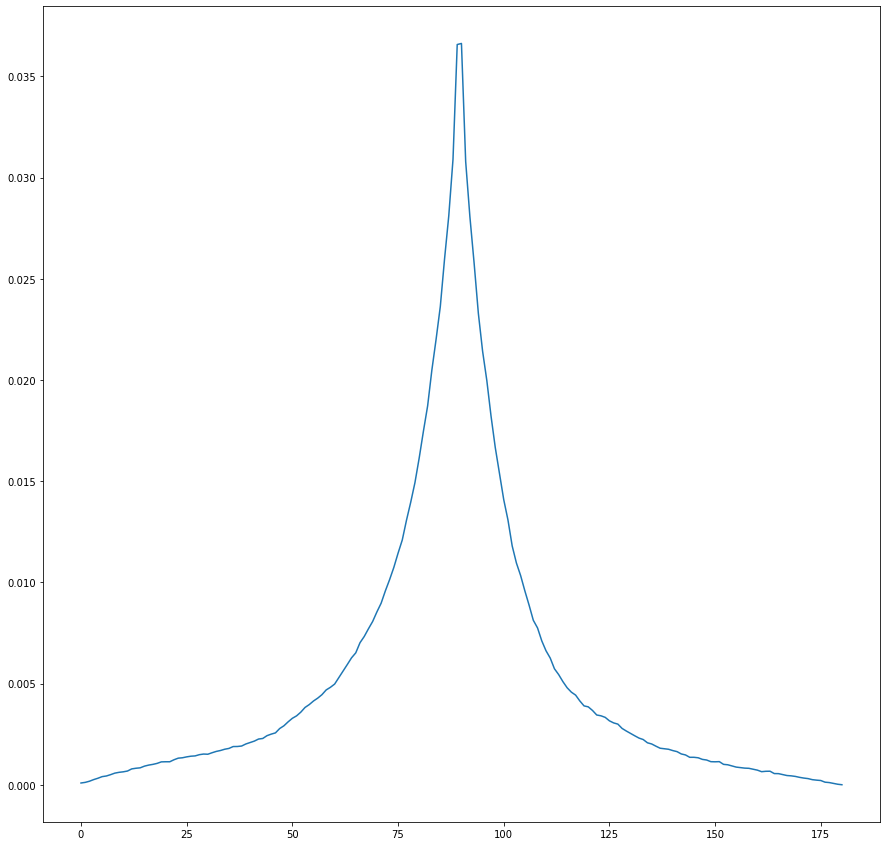

In [10]:
plt.figure(figsize=(15,15))
plt.plot(generates_n_plates(500000))
plt.savefig("cube.jpg")

In [11]:
vertex_distr = make_table_vertex_distribution(n=100000, n_try=10)
vertex_distr.to_csv('cube_vertex_distr.csv')

i got a problem with arccos Vector(-0.15030895397652372, 0.17838941819300808, 0.0) Vector(-0.15030895397652372, 0.17838941819300808, 0.0)
i got a problem with arccos Vector(0.15030895397652372, -0.17838941819300808, 0.0) Vector(0.15030895397652372, -0.17838941819300808, 0.0)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a problem with arccos Vector(0.0004165550864292378, 0.0, -6.413847597419586e-05) Vector(0.0004165550864292378, 0.0, -6.413847597419586e-05)
i got a problem with arccos Vector(-0.0004165550864292378, 0.0, 6.413847597419586e-05) Vector(-0.0004165550864292378, 0.0, 6.413847597419586e-05)
i got a problem with arccos Vector(0.0, 0.04317560100668183, 0.06600584866795955) Vector(0.0, 0.04317560100668183, 0.06600584866795955)
i got a problem with arccos Vector(0.0, -0.04317560100668183, -0.06600584866795955) Vector(0.0, -0.04317560100668183, -0.06600584866795955)
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i got a prob

,0,1,2,3,4,5,6
1,2.000000e-03,0.001000,0.012000,27.489000,49.866000,17.454000,5.176000
2,1.000000e-03,0.009000,0.009000,27.426000,50.225000,17.227000,5.103000
3,3.000000e-03,0.001000,0.008000,27.778000,49.796000,17.383000,5.031000
4,0.000000e+00,0.004000,0.008000,27.423000,49.850000,17.622000,5.093000
5,2.000000e-03,0.004000,0.004000,27.789000,49.690000,17.443000,5.068000
6,1.000000e-03,0.002000,0.005000,27.650000,49.739000,17.629000,4.974000
7,0.000000e+00,0.003000,0.005000,27.755000,49.719000,17.548000,4.970000
8,0.000000e+00,0.002000,0.005000,27.488000,50.021000,17.523000,4.961000
9,1.000000e-03,0.001000,0.005000,27.891000,49.666000,17.344000,5.092000
10,1.000000e-03,0.002000,0.006000,27.603000,49.976000,17.385000,5.027000


In [12]:
vertex_distr

,0,1,2,3,4,5,6
1,2.000000e-03,0.001000,0.012000,27.489000,49.866000,17.454000,5.176000
2,1.000000e-03,0.009000,0.009000,27.426000,50.225000,17.227000,5.103000
3,3.000000e-03,0.001000,0.008000,27.778000,49.796000,17.383000,5.031000
4,0.000000e+00,0.004000,0.008000,27.423000,49.850000,17.622000,5.093000
5,2.000000e-03,0.004000,0.004000,27.789000,49.690000,17.443000,5.068000
6,1.000000e-03,0.002000,0.005000,27.650000,49.739000,17.629000,4.974000
7,0.000000e+00,0.003000,0.005000,27.755000,49.719000,17.548000,4.970000
8,0.000000e+00,0.002000,0.005000,27.488000,50.021000,17.523000,4.961000
9,1.000000e-03,0.001000,0.005000,27.891000,49.666000,17.344000,5.092000
10,1.000000e-03,0.002000,0.006000,27.603000,49.976000,17.385000,5.027000
